In [18]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import integrate, optimize, stats
import seaborn as sns


plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 14
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

Load data from the text file

In [19]:
datafile = open('./../data/SCPUnion2.1_mu_vs_z.txt','r')
SCP_data = pd.read_table(datafile,comment='#',
                        names=['SN name','Redshift','Distance modulus',
                                   'Distance modulus error','P low mass'])
print(SCP_data)


    SN name  Redshift  Distance modulus  Distance modulus error  P low mass
0    1993ah  0.028488         35.346583                0.223906    0.128419
1    1993ag  0.050043         36.682368                0.166829    0.128419
2     1993o  0.052926         36.817691                0.155756    0.128419
3     1993b  0.070086         37.446737                0.158467    0.128419
4    1992bs  0.062668         37.483409                0.156099    0.128419
..      ...       ...               ...                     ...         ...
575   D-000  1.017000         44.293971                0.171046    0.000015
576   D-006  1.315000         44.971358                0.187509    0.551672
577   P-009  0.821000         43.640939                0.194014    0.551672
578   R-012  1.215000         45.246521                0.560317    0.000148
579   Z-005  0.623000         42.514524                0.241428    0.551672

[580 rows x 5 columns]


Some preliminary plots to visualize the data. 

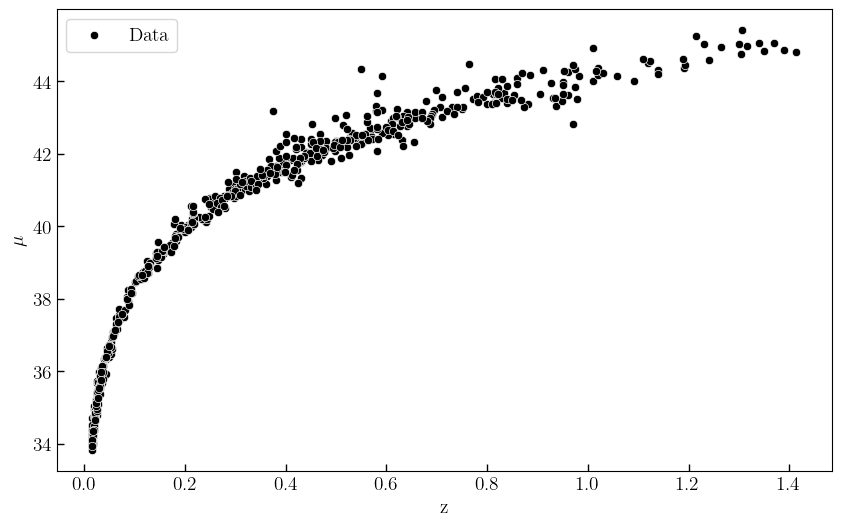

In [20]:
sns.scatterplot(x=SCP_data['Redshift'],y=SCP_data['Distance modulus'],label='Data',color='black');
plt.xlabel('z');
plt.ylabel(f'$\mu$');

Number of supernovae with z < 0.5: 412
Percentage of total data: 71.0%


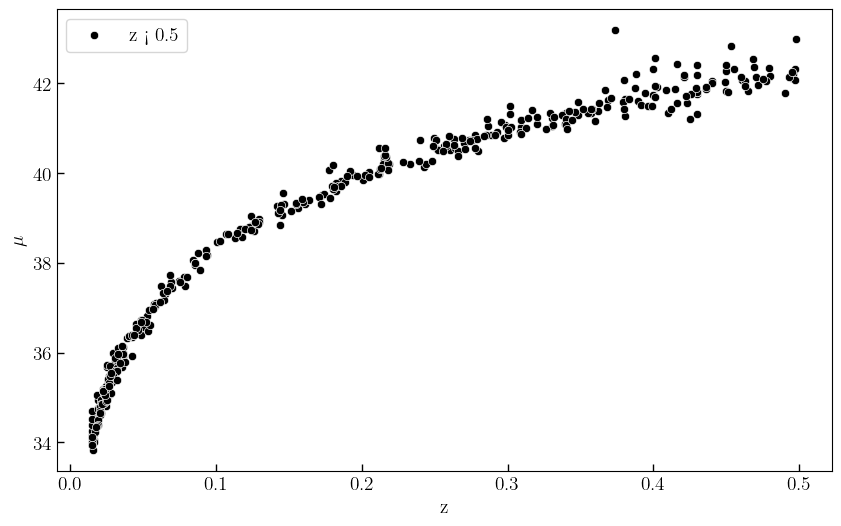

In [25]:
df_lowz = SCP_data[SCP_data['Redshift'] < 0.5].copy()

print(f"Number of supernovae with z < 0.5: {len(df_lowz)}")
print(f"Percentage of total data: {len(df_lowz)/len(SCP_data)*100:.1f}%")

# Low-z data scatter plot
sns.scatterplot(x=df_lowz['Redshift'],y=df_lowz['Distance modulus'],label=f'z < 0.5',color='black');
plt.xlabel('z');
plt.ylabel(f'$\mu$');

In [27]:
c = 299792.458  # Km/s
def distance_modulus_model(z, H0, q0):
    """
    d_L = c/H_0 (z+1/2(1-q_0)z^2)
    mu = 5 log(d_l)+25
    
    input: z, H0, q0
    output: mu
    
    """
    dL = (c / H0) * (z + 0.5 * (1 - q0) * z**2)
    
    mu = 5 * np.log10(dL) + 25
    return mu

In [77]:
def log_inverse_gamma(x, alpha, beta):
    return (alpha * np.log(beta) - scipy.special.gammaln(alpha) 
            - (alpha + 1) * np.log(x) - beta/x)

def log_prior(params):
    """
    Prior distributions for parameters [H0, q0, sigma]
    """
    H0, q0, sigma = params
    
    # Uniform priors for H0 and q0
    if not (50 < H0 < 100):
        return -np.inf
    if not (-2 < q0 < 2):
        return -np.inf
    if sigma <= 0:
        return -np.inf
    
    # Inverse Gamma prior for sigma^2 (intrinsic scatter)
    alpha = 2   # shape parameter
    beta = 0.1  # scale parameter
    log_prior_sigma = log_inverse_gamma(sigma, alpha, beta)
    
    return log_prior_sigma
    

In [78]:
def log_likelihood(params, z_data, mu_data, mu_err_data):
    """
    Gaussian log-likelihood with measurement errors and intrinsic scatter
    Uses data weights proportional to measurement errors
    """
    H0, q0, sigma = params
    #sigma = np.sqrt(sigma2)
    
    mu_model = distance_modulus_model(z_data, H0, q0)
    
    # Total variance = measurement error^2 + intrinsic scatter^2
    total_variance = mu_err_data**2 + sigma**2
    
    # Gaussian log-likelihood with weights
    logL = -0.5 * np.sum(
        (mu_data - mu_model)**2 / total_variance + 
        np.log(2 * np.pi * total_variance)
    )
    
    return logL

def log_posterior(params, z_data, mu_data, mu_err_data):
    """
    Total log posterior = log_prior + log_likelihood
    """
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    
    ll = log_likelihood(params, z_data, mu_data, mu_err_data)
    return lp + ll

def neg_log_posterior(params):
    return -log_posterior(params, z_data, mu_data, mu_err_data)

In [79]:
z_data = df_lowz['Redshift'].values
mu_data = df_lowz['Distance modulus'].values
mu_err_data = df_lowz['Distance modulus error'].values

Now we can find MAP Estimate:

In [80]:
initial_guess = [70, -0.5, 0.2] # H0,q0, sigma2

In [81]:
print("Finding MAP estimate:")
result = minimize(neg_log_posterior, initial_guess, method='Nelder-Mead')

Finding MAP estimate:


In [82]:
if result.success:
    map_estimate = result.x
    print("MAP Estimation success")
    print(f"H₀ = {map_estimate[0]:.2f} km/s/Mpc")
    print(f"q₀ = {map_estimate[1]:.3f}")
    print(f"σ² = {map_estimate[2]:.3f} (variance)")
else:
    print("MAP Estimation failed")
    map_estimate = initial_guess

MAP Estimation success
H₀ = 69.77 km/s/Mpc
q₀ = -0.418
σ² = 0.025 (variance)


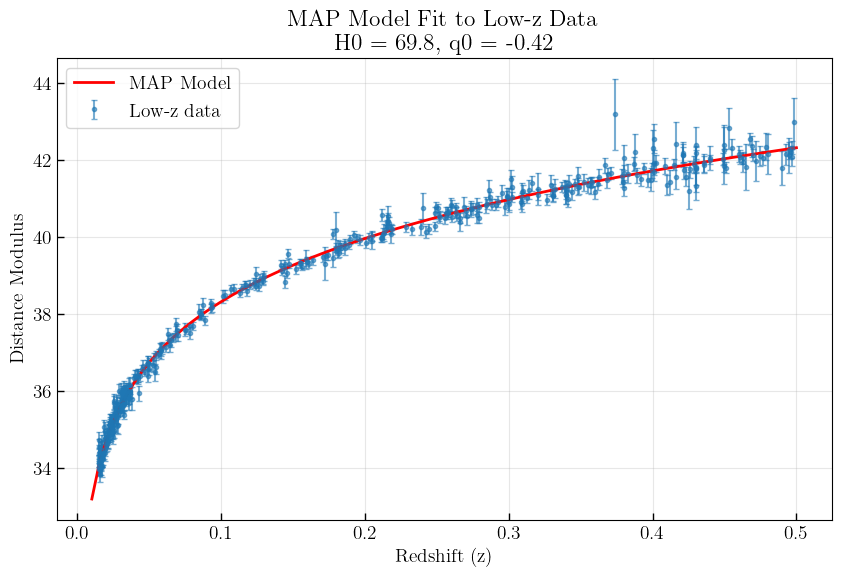

In [83]:
plt.figure(figsize=(10, 6))
z_plot = np.linspace(0.01, 0.5, 100)
mu_plot = distance_modulus_model(z_plot, map_estimate[0], map_estimate[1])

plt.errorbar(z_data, mu_data, yerr=mu_err_data, fmt='o', alpha=0.6, 
             label='Low-z data', markersize=3, capsize=2)
plt.plot(z_plot, mu_plot, 'r-', linewidth=2, label='MAP Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus')
plt.title(f'MAP Model Fit to Low-z Data\nH0 = {map_estimate[0]:.1f}, q0 = {map_estimate[1]:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

MCMC Sampling:

In [84]:
nwalkers = 32
ndim = 3  # H0, q0, sigma
nsteps = 2000
burnin = 500

In [85]:
initial_pos = map_estimate + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, 
    args=(z_data, mu_data, mu_err_data)
)


In [86]:
print("Running MCMC.....")
sampler.run_mcmc(initial_pos, nsteps, progress=True)
samples = sampler.chain[:, burnin:, :].reshape(-1, ndim)
H0_samples, q0_samples, sigma_samples = samples[:, 0], samples[:, 1], samples[:, 2]
print(f"MCMC complete: {len(samples)} posterior samples")

You must install the tqdm library to use progress indicators with emcee


Running MCMC.....
MCMC complete: 48000 posterior samples


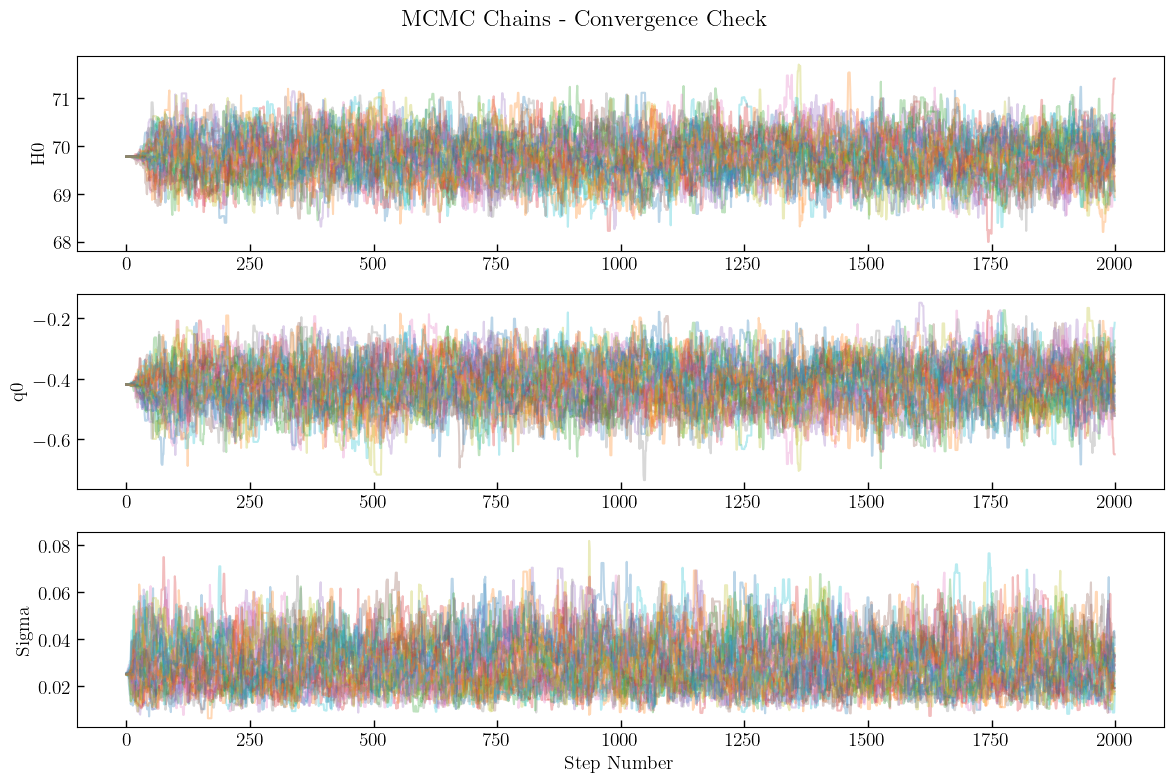

In [87]:
plt.figure(figsize=(12, 8))
for i, param_name in enumerate(['H0', 'q0', 'Sigma']):
    plt.subplot(3, 1, i+1)
    plt.plot(sampler.chain[:, :, i].T, alpha=0.3)
    plt.ylabel(param_name)
    if i == 2:
        plt.xlabel('Step Number')
plt.suptitle('MCMC Chains - Convergence Check')
plt.tight_layout()
plt.show()

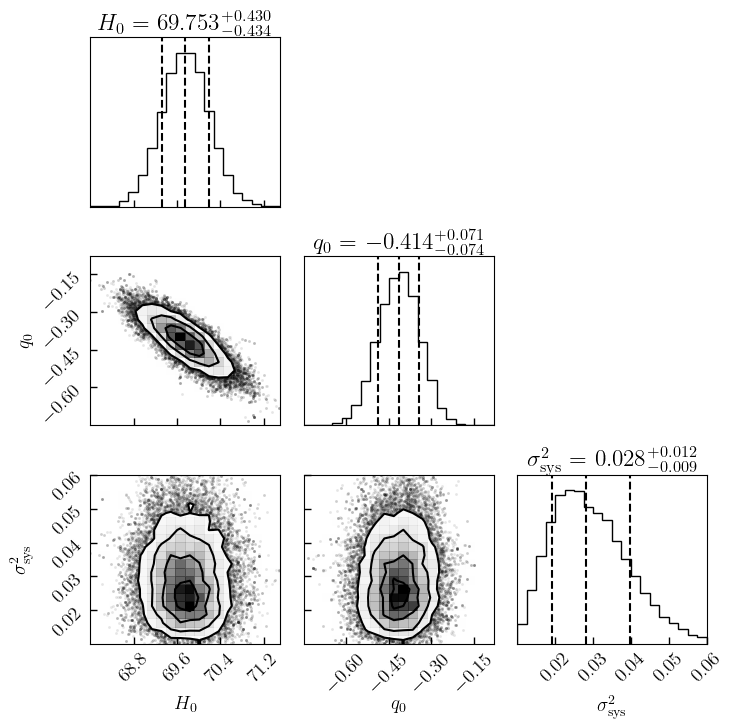

In [99]:
fig = corner.corner(np.vstack([H0_samples, q0_samples, sigma_samples]).T,
                    labels=[r"$H_0$", r"$q_0$", r"$\sigma_{\mathrm{sys}}^2$"],
                    range=[[68, 71.5], [-0.75, -0.08], [0.01, 0.06]],
                    show_titles=True,
                    title_fmt=".3f",
                    quantiles=[0.16, 0.5, 0.84])

plt.tight_layout()
# plt.savefig("posterior_histograms.png")
plt.show()

TASK 1 RESULTS
H0 = 69.8 +0.4 -0.4 km/s/Mpc
q0 = -0.414 +0.071 -0.074
Intrinsic scatter variance = 0.007
Intrinsic scatter std dev = 0.028


<Figure size 1000x800 with 0 Axes>

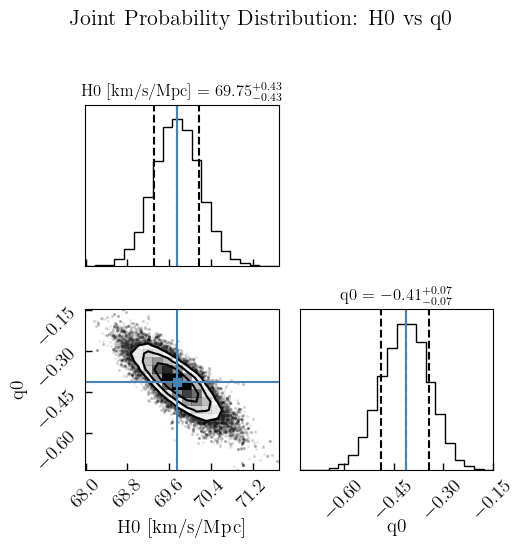

In [93]:
# Calculate summary statistics
H0_median = np.median(H0_samples)
H0_low, H0_high = np.percentile(H0_samples, [16, 84])

q0_median = np.median(q0_samples)
q0_low, q0_high = np.percentile(q0_samples, [16, 84])

sigma2_median = np.median(sigma2_samples)
sigma_median = np.median(sigma_samples)

print("TASK 1 RESULTS")
print(f"H0 = {H0_median:.1f} +{H0_high-H0_median:.1f} -{H0_median-H0_low:.1f} km/s/Mpc")
print(f"q0 = {q0_median:.3f} +{q0_high-q0_median:.3f} -{q0_median-q0_low:.3f}")
print(f"Intrinsic scatter variance = {sigma2_median:.3f}")
print(f"Intrinsic scatter std dev = {sigma_median:.3f}")

# Create corner plot
try:
    plt.figure(figsize=(10, 8))
    corner.corner(
        samples[:, :2],  # Only H0 and q0
        labels=['H0 [km/s/Mpc]', 'q0'],
        truths=[H0_median, q0_median],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12}
    )
    plt.suptitle('Joint Probability Distribution: H0 vs q0', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Corner plot failed: {e}")

ACCELERATION ANALYSIS
Probability that q0 < 0: 100.0%


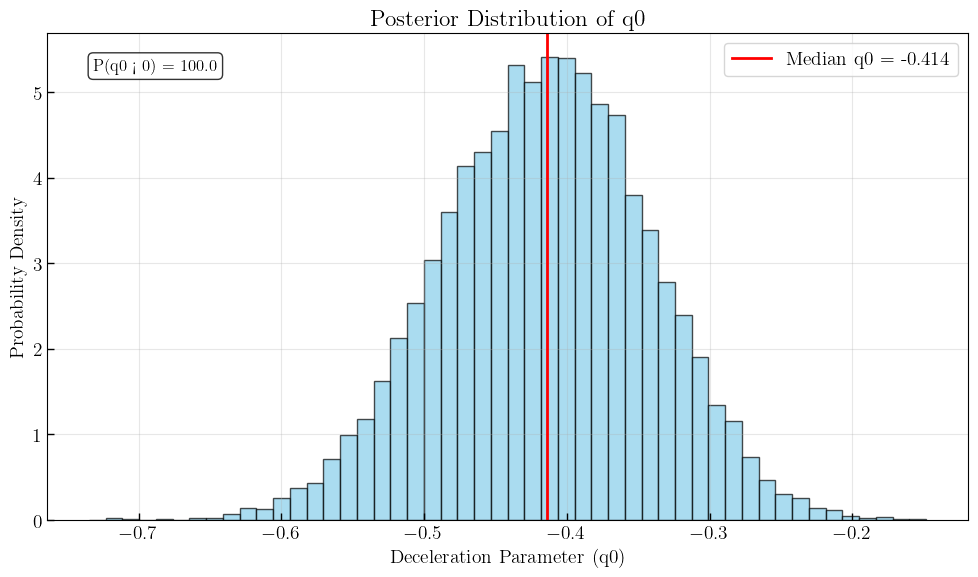


CONCLUSION: Strong evidence for accelerating expansion (q0 < 0)


In [92]:
# Calculate probability of accelerating expansion (but don't emphasize the threshold)
prob_accelerating = np.mean(q0_samples < 0)

print(f"Probability that q0 < 0: {prob_accelerating*100:.1f}%")

# Plot q0 posterior distribution - CLEAN VERSION without "no acceleration" line
plt.figure(figsize=(10, 6))
plt.hist(q0_samples, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(q0_median, color='red', linestyle='-', linewidth=2, 
            label=f'Median q0 = {q0_median:.3f}')
plt.xlabel('Deceleration Parameter (q0)')
plt.ylabel('Probability Density')
plt.title('Posterior Distribution of q0')

# Add probability text box (discreet)
textstr = f'P(q0 < 0) = {prob_accelerating*100:.1f}%'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

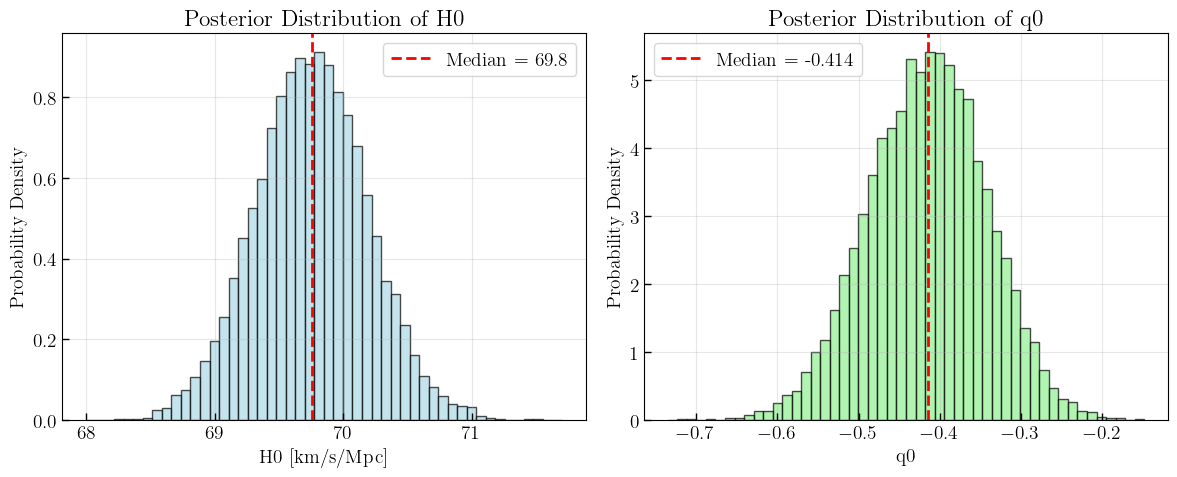

In [94]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# H0 marginal probabilities
ax1.hist(H0_samples, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black')
ax1.axvline(H0_median, color='red', linestyle='--', linewidth=2, 
            label=f'Median = {H0_median:.1f}')
ax1.set_xlabel('H0 [km/s/Mpc]')
ax1.set_ylabel('Probability Density')
ax1.set_title('Posterior Distribution of H0')
ax1.legend()
ax1.grid(True, alpha=0.3)

# q0 marginal probabilities
ax2.hist(q0_samples, bins=50, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.axvline(q0_median, color='red', linestyle='--', linewidth=2, 
            label=f'Median = {q0_median:.3f}')
ax2.set_xlabel('q0')
ax2.set_ylabel('Probability Density')
ax2.set_title('Posterior Distribution of q0')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

TASK 2

In [100]:
H0_fixed = 70.0

def hubble_parameter_lcdm(z, Omega_m0):
    return H0_fixed * np.sqrt(Omega_m0 * (1 + z)**3 + (1 - Omega_m0))
    
def hubble_parameter_wcdm(z, Omega_m0, w):
    return H0_fixed * np.sqrt(Omega_m0 * (1 + z)**3 + (1 - Omega_m0) * (1 + z)**(3*(1 + w)))

def luminosity_distance(z, hubble_func, params):
    def integrand(zp):
        return 1.0 / hubble_func(zp, *params)
    
    if np.isscalar(z):
        integral, _ = integrate.quad(integrand, 0, z)
        return c * (1 + z) * integral
    # For array z
    else:
        dL = np.zeros_like(z)
        for i, zi in enumerate(z):
            integral, _ = integrate.quad(integrand, 0, zi)
            dL[i] = c * (1 + zi) * integral
        return dL
def distance_modulus(z, hubble_func, params):
    dL = luminosity_distance(z, hubble_func, params)
    return 5 * np.log10(dL) + 25



In [102]:
def log_likelihood_lcdm(params, z_data, mu_data, mu_err_data):
    """
    Only depends on Omega_m0
    """
    Omega_m0 = params[0]
    
    # Prior: omega_m0 must be between 0 and 1
    if not (0 <= Omega_m0 <= 1):
        return -np.inf
    
    # Model predictions
    mu_model = distance_modulus(z_data, hubble_parameter_lcdm, [Omega_m0])
    
    # Gaussian log-likelihood with known measurement variance
    chi2 = np.sum((mu_data - mu_model)**2 / mu_err_data**2)
    logL = -0.5 * chi2
    
    return logL

In [103]:
def log_likelihood_wcdm(params, z_data, mu_data, mu_err_data):
    """
    depends on OMega_m0, w
    """
    Omega_m0, w = params
    
    # Priors
    if not (0 <= Omega_m0 <= 1) or w < -2 or w > 0:
        return -np.inf
    
    # Model predictions
    mu_model = distance_modulus(z_data, hubble_parameter_wcdm, [Omega_m0, w])
    
    # Gaussian log-likelihood with known measurement variance
    chi2 = np.sum((mu_data - mu_model)**2 / mu_err_data**2)
    logL = -0.5 * chi2
    
    return logL


In [104]:
initial_lcdm = [0.3]#omega_m0

def neg_log_likelihood_lcdm(params):
    return -log_likelihood_lcdm(params, z_data, mu_data, mu_err_data)

result_lcdm = minimize(neg_log_likelihood_lcdm, initial_lcdm, method='Nelder-Mead')

if result_lcdm.success:
    print("Success")
    Omega_m0_mle_lcdm = result_lcdm.x[0]
    logL_max_lcdm = -result_lcdm.fun
    print(f"lCDM MLE: Ω_m0 = {Omega_m0_mle_lcdm:.4f}")
    print(f"Max log-likelihood: {logL_max_lcdm:.2f}")
else:
    print("lCDM MLE failed")
    Omega_m0_mle_lcdm = initial_lcdm
    logL_max_lcdm = log_likelihood_lcdm([Omega_m0_mle_lcdm], z_data, mu_data, mu_err_data)



Success
lCDM MLE: Ω_m0 = 0.2627
Max log-likelihood: -192.79
